# Quantium Virtual Internship
## Notebook 1
## Data pre-processing

## The task
We need to analyse the data to understand current purchasing trends and behaviours. The client is particularly interested in customer segments and their chip purchasing behaviour. Consider what metrics would help describe the customers’ purchasing behaviour.  

### Datasets:  
QVI_purchase_behaviour.csv  
QVI_transaction_data.xlsx

# EDA
High level data checks:  
- summaries of the data  
- sind outliers and removing these  
- Check data formats and correct   

Derive extra features:  
- pack size  
- brand name

Examine:  
- inconsistencies  
- missing data  
- correctly identified category items  

Our insights need to have a commercial application as our end goal is to form a strategy based on the findings to provide a clear recommendation to the Category Manager. 

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('magma')
from datetime import datetime
from datetime import timedelta

In [122]:
df = pd.read_excel('data/QVI_transaction_data.xlsx')
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [123]:
df.shape

(264836, 8)

# Explore date 

Date is in an old format of days after 30/12/1899, let's convert it to datetime.  
info https://support.smartbear.com/testcomplete/docs/scripting/working-with/dates/python.html  

In [124]:
# convert 'DATE' columns (which is number of days from 'zero time' 30 Dec 1899) to datetime object
def format_date(date):
    zero = datetime(1899, 12, 30)
    delta = zero + timedelta(date) # add number of days from 'zero date'
    return delta

In [125]:
print(format_date(43330))
print(type(format_date(43330)))

2018-08-18 00:00:00
<class 'datetime.datetime'>


In [126]:
df['DATE'] = df['DATE'].apply(lambda date: format_date(date))

In [127]:
# transactions from one day are missing
first = df['DATE'].min()
last = df['DATE'].max()
print('First day:', first)
print('Last day:', last)
print('Number of unique dates:', df['DATE'].nunique())

First day: 2018-07-01 00:00:00
Last day: 2019-06-30 00:00:00
Number of unique dates: 364


In [128]:
# find the missing date
pd.date_range(start=first, end=last).difference(df['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

Missing date is Christmas day, when the shop is closed so it is not an anomaly

In [129]:
# create a table with the missing date
add_missing_date = pd.merge(pd.Series(pd.date_range(start=first, end=last), name='DATE'), df, on='DATE', how='left')

In [130]:
add_missing_date['DATE'].value_counts().sort_values().head()

2018-12-25      1
2018-11-25    648
2018-10-18    658
2019-06-13    659
2019-06-24    662
Name: DATE, dtype: int64

### Transactions over time

In [131]:
# visualise number of transaction in given time period
year_trans = add_missing_date['DATE'].value_counts().sort_index()

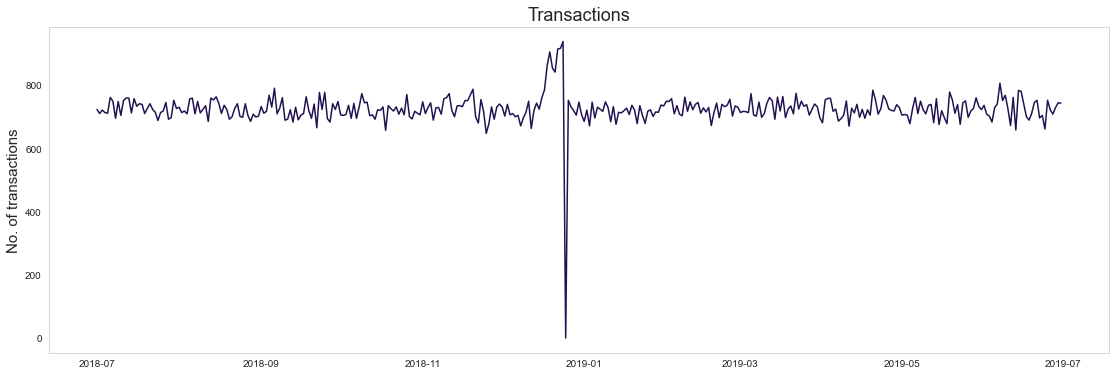

In [132]:
# plot number of transactions over the year
plt.figure(figsize=(19,6))
plt.grid(False)
plt.ylabel('No. of transactions', fontsize=15)
plt.plot(year_trans)
plt.title('Transactions', fontsize=18);
# plt.savefig('viz/trans_year.jpg')

In [133]:
# explore December
dec = year_trans[(year_trans.index >= pd.datetime(2018,12,1)) & (year_trans.index < pd.datetime(2019,1,1))]

/Users/helenahook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



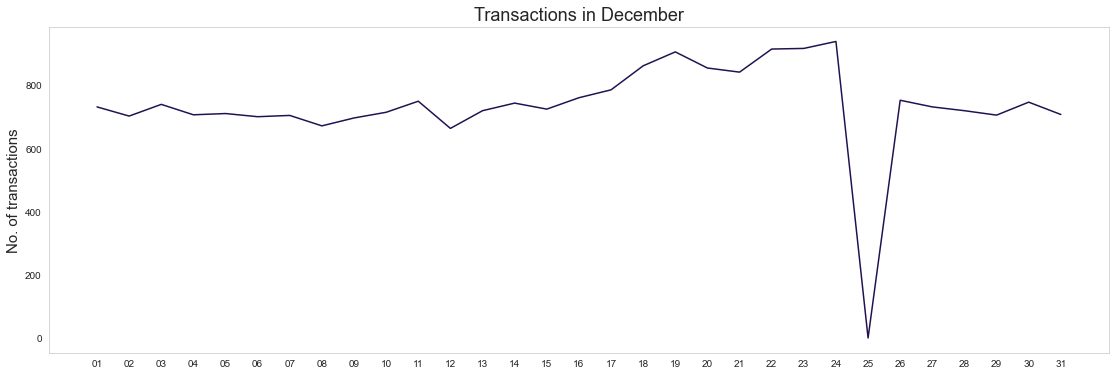

In [134]:
# plot number of transactions in December
plt.figure(figsize=(19,6))
plt.grid(False)

dec.index = dec.index.strftime('%d')
positions = np.arange(0, 31)
labels = dec.index
plt.xticks(positions, labels)

plt.ylabel('No. of transactions', fontsize=15)
plt.plot(dec)
plt.title('Transactions in December', fontsize=18);
# plt.savefig('viz/trans_dec.jpg')

# Derive features

### Weight

In [135]:
# function to get the weight of pack
def get_weight(name):
    if name.startswith('Kettle 135g'): 
        return name[7:10].strip()
    else:
        return name[-4:-1].strip()

In [136]:
df['weight'] = df['PROD_NAME'].apply(lambda x: get_weight(x))

In [137]:
# change weight data type to integer
df['weight'] = df['weight'].astype(int)

In [138]:
w_counts = df['weight'].value_counts()

In [139]:
import plotly.express as px
import plotly.graph_objects as go

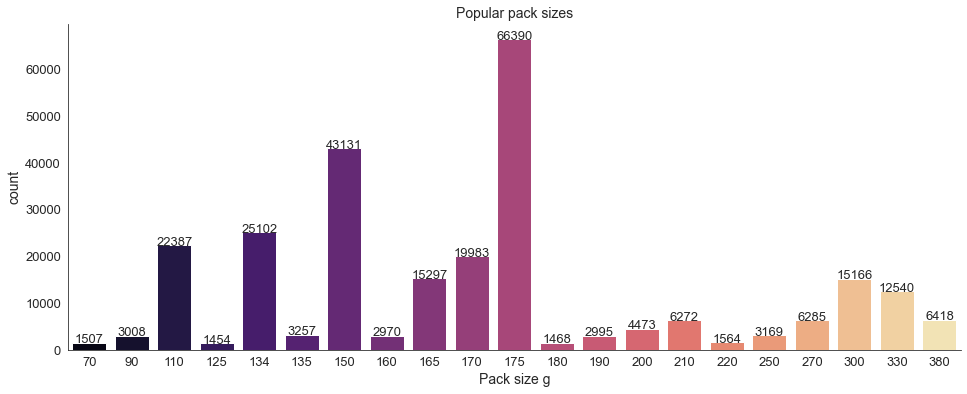

In [140]:
# plot pack sizes
plt.figure(figsize=(16,6))
sns.set_style('white')

q = w_counts
y = q.values
x = q.index

ax = sns.barplot(x=x, y=y, palette='magma')
sns.despine(top=True, right=True)

# label each bar 
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
    y = height+0.7, # y-coordinate position of data label, padded 0.2 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center', # sets horizontal alignment (ha) to center
    fontsize=13)

plt.xlabel('Pack size g', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Popular pack sizes', fontsize=14);
# plt.savefig('viz/pack_sizes.png')

In [141]:
# because there are many different pack weights we will group weights in 4 categories
# create weight_bin, group weight classes
def weight_bin(weight):
    if weight <= 110:
        return '70-110g'
    elif (weight > 110) & (weight <= 150):
        return '125-150g'
    elif (weight > 150) & (weight <= 175):
        return '160-175g'
    else:
        return '180-380g'

In [142]:
df['weight_bin'] = df['weight'].apply(lambda x: weight_bin(x))

In [143]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight,weight_bin
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,160-175g
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,160-175g
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,160-175g
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,160-175g
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,125-150g


### Brand name

In [144]:
# get brand name
df['brand'] = df['PROD_NAME'].apply(lambda x: x.split()[0])

In [145]:
# check brand names
df['brand'].value_counts()

Kettle        41288
Smiths        28860
Pringles      25102
Doritos       24962
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Old            9324
Tyrrells       6442
Grain          6272
Natural        6050
Red            5885
Cheezels       4603
CCs            4551
Woolworths     4437
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: brand, dtype: int64

In [146]:
# combine brand names written in different ways
df.loc[df['PROD_NAME'].str.startswith('Red'), ['brand']] = 'Red Rock Deli'
df.loc[df['PROD_NAME'].str.startswith('Old'), ['brand']] = 'Old El Paso'
df.loc[df['PROD_NAME'].str.startswith('Dorito'), ['brand']] = 'Doritos'
df.loc[df['PROD_NAME'].str.startswith('Natural'), ['brand']] = 'Natural Chip Co'
df.loc[df['PROD_NAME'].str.startswith('NCC'), ['brand']] = 'Natural Chip Co'
df.loc[df['PROD_NAME'].str.startswith('Infzns'), ['brand']] = 'Infuzions'
df.loc[df['PROD_NAME'].str.startswith('Snbts'), ['brand']] = 'Sunbites'
df.loc[df['PROD_NAME'].str.startswith('GrnWves'), ['brand']] = 'Sunbites'
df.loc[df['PROD_NAME'].str.startswith('Burger'), ['brand']] = 'Smiths'
df.loc[df['PROD_NAME'].str.startswith('Smith'), ['brand']] = 'Smiths'
df.loc[df['PROD_NAME'].str.startswith('French'), ['brand']] = 'French Fries'

### Wrong categories
#### Explore products

In [147]:
# Old El Paso Salsa Dips are wrongly categories under chips
df[df['PROD_NAME'].str.startswith('Old')]['PROD_NAME'].value_counts()

Old El Paso Salsa   Dip Chnky Tom Ht300g    3125
Old El Paso Salsa   Dip Tomato Med 300g     3114
Old El Paso Salsa   Dip Tomato Mild 300g    3085
Name: PROD_NAME, dtype: int64

In [148]:
# Woolworth salsas wrongly categorised
df[(df['brand']=='Woolworths') & (df['PROD_NAME'].str.contains('Salsa'))]['PROD_NAME'].value_counts()

Woolworths Mild     Salsa 300g    1491
Woolworths Medium   Salsa 300g    1430
Name: PROD_NAME, dtype: int64

In [149]:
# Doritos salsas wrongly categorised
df[(df['brand']=='Doritos') & (df['PROD_NAME'].str.contains('Salsa'))]['PROD_NAME'].value_counts()

Doritos Salsa Mild  300g           1472
Doritos Salsa       Medium 300g    1449
Name: PROD_NAME, dtype: int64

In [150]:
# dip in Smiths brand is just a name for chip flavor, not wrongly categorised
df[(df['PROD_NAME'].str.contains('Dip')) & (df['brand']=='Smiths')]['PROD_NAME'].value_counts()

Smiths Crinkle Cut  French OnionDip 150g    1438
Name: PROD_NAME, dtype: int64

In [151]:
# identify all Old El Paso dip product rows
old_el = df[df['PROD_NAME'].str.startswith('Old')].index
# identify Doritos salsas
doritos_salsa = df[(df['brand']=='Doritos') & (df['PROD_NAME'].str.contains('Salsa'))].index
# identify Woolworth salsas
woolworth_salsa = df[(df['brand']=='Woolworths') & (df['PROD_NAME'].str.contains('Salsa'))]['PROD_NAME'].index

In [152]:
# remove Old El Paso dips, Doritos salsas and Woolworths salsas
df = df.drop(old_el)
df = df.drop(doritos_salsa)
df = df.drop(woolworth_salsa)

# Stores

In [153]:
# we have 271 different stores
df['STORE_NBR'].nunique()

271

# Product quantities

In [154]:
# found 2 outliers with 200 product qunatities
df['PROD_QTY'].value_counts()

2      222618
1       25844
5         419
3         412
4         375
200         2
Name: PROD_QTY, dtype: int64

In [155]:
# made by the same customer
df[df['PROD_QTY']==200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight,weight_bin,brand
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380,180-380g,Doritos
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380,180-380g,Doritos


In [156]:
# remove those records from our dataset
df = df[df['PROD_QTY']<6]

# Output processed data set

In [157]:
df.to_csv('data/clean_quantium_transaction_data.csv', index=False)
print('File saved!')

File saved!
